In [12]:
import sys
sys.path.append('..')

import os
from sqlalchemy import create_engine, text
import geopandas as gpd
import pandas as pd

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import API_AMIGOCLOUD_TOKEN_ADM
from config import POSTGRES_UTEA

In [13]:
def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )


In [36]:
def get_catastro():
    engine = obtener_engine()
    try:
        query = f'''
            SELECT * FROM catastro_iag.catastro
        '''
        gdf = gpd.read_postgis(query, engine, geom_col='geom')
        return gdf
    except Exception as e:
        print(f"❌ Error al obtener la capa de catastro: {e}")
        return gpd.GeoDataFrame()
    return None

In [37]:
gdf_catrastro = get_catastro()

In [38]:
gdf_catrastro.columns

Index(['idd', 'geom', 'id', 'unidad_01', 'unidad_02', 'unidad_03', 'unidad_04',
       'unidad_05', 'variedad', 'soca', 'zona', 'textura', 'cultivo',
       'financia', 'fs', 'area', 'fc', 'codco', 'zafra', 'seguimient',
       'estado', 'fci', 'tipoc', 'lote_admin', 'delagado', 'iag'],
      dtype='object')

In [64]:
dict_propiedades = {
    30: "CAMPODULCE",
    259: "SANTA ANA DE PAILON",
    482: "TEXAS",
    480: "EL CANAL",
    2250: "COSORIOCITO",
    2307: "CAMBERRA",
    2238: "EL PARAISO",
    577: "SAN ANTONIO--IAG",
    299: "CITTCA",
    2257: "TODOS SANTOS--CITTCA",
    122: "LAS CHACRAS-- WENDE"
}

In [90]:
# paramtros
# socas mas jovenes
soca = 3
# variedad con riesgo
variedades = ['RB2','RB4','RBB7726']
# lista de codigos de propiedades para liberacion 800m al rededor
lista_codigos_props = list(dict_propiedades)

In [71]:
# filtar caña habilitada para para zafra actual
gdf_catastro_canha = gdf_catrastro[(gdf_catrastro['unidad_03'] != 0) & (gdf_catrastro['cultivo'] == 'canha') & (gdf_catrastro['zafra'] == 2026)]

In [87]:
# crea un disolve de catastro agrupado por unidad_01, y no convertir unidad_01 en index
gdf_catastro_disuelto = gdf_catastro_canha.dissolve(by='unidad_01', as_index=False)

In [100]:
# seleccionar el disolve solo de las propiedades de la listra
select_buffer_props = gdf_catastro_disuelto[gdf_catastro_disuelto['unidad_01'].isin(lista_codigos_props)]

In [103]:
select_buffer_props.columns

Index(['unidad_01', 'geom', 'idd', 'id', 'unidad_02', 'unidad_03', 'unidad_04',
       'unidad_05', 'variedad', 'soca', 'zona', 'textura', 'cultivo',
       'financia', 'fs', 'area', 'fc', 'codco', 'zafra', 'seguimient',
       'estado', 'fci', 'tipoc', 'lote_admin', 'delagado', 'iag'],
      dtype='object')

In [104]:
# copiar dataset de disolve de propiedaes y aplicar buffer de 800m
gdf_buffer = select_buffer_props[['unidad_01', 'geom']].copy()
gdf_buffer['geom'] = gdf_buffer.buffer(800)

In [111]:
# interseccion entree el buffer de las propiedades de interes y el catastro
gdf_interseccion = gpd.overlay(gdf_catastro_canha, gdf_buffer, how='intersection')

In [123]:
# crear lista de codigos de propiedades al rededor de las porpiedades de interes
lista_props_alrededor = list(set(gdf_interseccion['unidad_01_1']))
lista_props_alrededor = [int(i) for i in lista_props_alrededor]
print(lista_props_alrededor)

[519, 1545, 9, 12, 1039, 1041, 18, 19, 2068, 26, 30, 2096, 2108, 577, 1100, 78, 79, 592, 593, 2136, 1115, 1116, 1123, 1124, 122, 123, 2192, 1682, 1683, 1686, 2210, 174, 699, 2238, 1221, 2250, 2257, 213, 218, 220, 2295, 768, 259, 260, 261, 2309, 2307, 264, 1299, 279, 797, 811, 299, 2351, 1852, 325, 860, 866, 895, 907, 909, 1934, 910, 404, 405, 407, 1436, 418, 421, 937, 938, 941, 1454, 951, 440, 953, 1479, 473, 2012, 480, 482, 1009, 2035, 2046]


<Axes: >

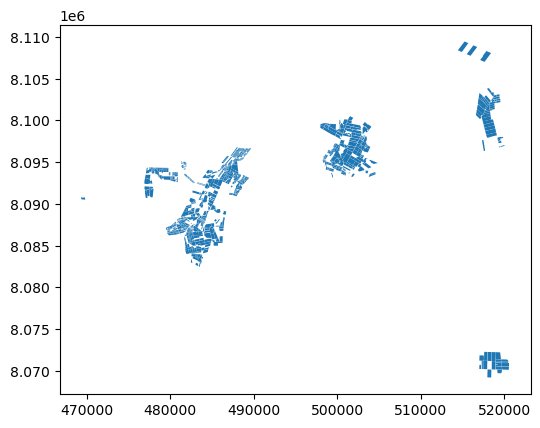

In [125]:
gdf_catastro_canha[gdf_catastro_canha['unidad_01'].isin(lista_props_alrededor)].plot()

In [127]:

# filtara cortes mas jovenes soca <= 3
gdf_catastro_canha = gdf_catastro_canha[
    (gdf_catastro_canha['soca'] <= soca) |
    (gdf_catastro_canha['variedad'].isin(variedades) & (gdf_catastro_canha['soca'] <= soca)) |
    (gdf_catastro_canha['unidad_01'].isin(lista_props_alrededor))
]

In [62]:
gdf_catastro_canha['area'].sum()

30117.626153472756